### Evaluating NARVAL R2B4 on NARVAL R2B5

**For Figure S5**

Note that by scaling the data not until the single batches are predicted, we only need a fraction of memory (<50GB or so)! So far we have first scaled the data and then predicted the batches which sometimes exceeds 500GB.

In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

# Add path with my_classes to sys.path
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/') 

# Add path with for_preprocessing to sys.path (for the region-based model)
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/region_based/source_code')

# Add path with functions to sys.path
sys.path.insert(0, '/additional_content/plots_offline_paper/auxiliary')

import functions
from my_classes import load_data
from my_classes import read_mean_and_std
import for_preprocessing
importlib.reload(for_preprocessing)
importlib.reload(functions)
from for_preprocessing import load_day

from tensorflow.keras import backend as K

from tensorflow import nn 
from tensorflow.keras.models import load_model

ORDER_OF_VARS_NARVAL = ['qv', 'qc', 'qi', 'temp', 'pres', 'rho', 'u', \
                        'v', 'zg', 'coriolis', 'fr_land', 'fr_lake', 'clc', 'cl_area']
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (1721, 31, 4450) # For Narval data

In [2]:
import matplotlib

# Increase the general font size in plots
size_plots_label = 11
matplotlib.rcParams['legend.fontsize'] = size_plots_label
matplotlib.rcParams['axes.labelsize'] = size_plots_label # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = size_plots_label+2 # For an axes xlabel and ylabel
matplotlib.rcParams['xtick.labelsize'] = size_plots_label
matplotlib.rcParams['ytick.labelsize'] = size_plots_label

# Averaged over the NARVAL region
zg_mean_narval = [20785,19153,17604,16134,14741,13422,12175,10998,9890,8848,
                  7871,6958,6107,5317,4587,3915,3300,2741,2237,1787,1390,1046,
                  754,515,329,199,128] # in meters

zg_mean_narval = np.round(np.array(zg_mean_narval)/1000, decimals=1) # in kilometers

# Averaged globally
zg_mean_qubicc = [20785,19153,17604,16134,14742,13424,12178,11002,9896,8857,
                  7885,6977,6133,5351,4630,3968,3363,2814,2320,1878,1490,1153,
                  867,634,452,324,254] # in meters
zg_mean_qubicc = np.round(np.array(zg_mean_qubicc)/1000, decimals=1) # in kilometers

green='#004D40'
red='#D81B60'
blue='#1E88E5'

### Scaling parameters
Taken from scalings.txt

In [ ]:
# Cell-based
cell_mean, cell_std = read_mean_and_std('/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_cell_based_v3/saved_models/model_grid_cell_based_v3_final_1.txt')

# Column-based
column_mean, column_std = read_mean_and_std('/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based/saved_models/model_grid_column_based_final_1.txt')

### Computations

#### **Cloud Cover** - Mean and R2, **NARVAL R2B5** data

In [ ]:
# First we have to load the NARVAL data (if not already done so)
try:
    narval_data
except:    
    narval_data = load_data(source='narval', days='all', vert_interp=True, resolution='R02B05', 
                        order_of_vars=ORDER_OF_VARS_NARVAL)

**The cell-based model**

In [ ]:
model_type = 'grid_cell_based_v3'

# Be careful to pass a copy of narval_data
data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='model_grid_cell_based_v3_final_1.h5', 
                                                      model_mean=cell_mean, model_std=cell_std, 
                                                      data_source='narval', 
                                                      narval_data=narval_data.copy())

In [ ]:
functions.write_to_file(model_type_short='Cell-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile,
                       model_training_source='narval')

**The column-based model**

In [ ]:
model_type = 'grid_column_based'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='model_grid_column_based_final_1.h5', 
                                                      model_mean=column_mean, model_std=column_std,
                                                      data_source='narval', 
                                                      narval_data=narval_data.copy())

In [ ]:
functions.write_to_file(model_type_short='Column-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile,
                       model_training_source='narval')

**The region-based model** <br>
I'm not going to delegate it to the python-file and instead compute stuff here

In [ ]:
# Load model
clc_model_path = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/region_based/saved_models/'
models = [load_model(os.path.join(clc_model_path, 'model_clc_all_days_final_1_%d.h5'%i)) for i in range(27)]

In [ ]:
# Load data: Takes 61 seconds to load one day. Have 67 days. So loading all data would take 70 minutes. We start with two days.
path = "/pf/b/b309170/my_work/NARVAL/data_var_vertinterp_R02B05/"

# Read all days
ls = os.listdir(os.path.join(path, 'temp')) #Temperature as an arbitrary variable
days = set()
for j in range(len(ls)):
    day = ls[j].split(sep='_')[5][:8] #Days in NARVAL
    days.add(day)

no_remaining_days = 0 # 0 to load all days 
no_of_days = len(days) - no_remaining_days

timesteps_per_day = 36
n_layers = 27 # Is also the number of NNs
TIME_STEPS = timesteps_per_day*no_of_days
# HORIZ_FIELDS = len(dfs[0]['clc'])//TIME_STEPS
HORIZ_FIELDS = 4450

# Store all days in an array of dataframes (each row is a training sample for the NN)
dfs = load_day(days.pop(), n_layers, path, data_source='narval', resolution_narval='R02B05')
while len(days) > no_remaining_days: #while len(days) > 0 to load all days
    tmp = load_day(days.pop(), n_layers, path, data_source='narval', resolution_narval='R02B05')
    for i in range(n_layers):
        # Have 2424 instead of 2412 timesteps if we load Barbados_20150830 entirely!
        # Therefore I added [:timesteps_per_day*HORIZ_FIELDS]
        dfs[i] = dfs[i].append(tmp[i][:timesteps_per_day*HORIZ_FIELDS], ignore_index=True)

In [ ]:
# Usually in QUBICC hc2: (TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (721, 27/31, 14826)
# Usually in NARVAL: (TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (1635, 75/31/27, 1306)

## Load data pertaining to a specific NN
n_samples_per_layer = dfs[0].shape[0]
n_features = dfs[0].shape[1] - 1

# Where's the temporal information?
# It's spaced 14826 entries apart in QUBICC (=n_samples_per_layer/(timesteps_per_day*no_of_days)):
temp_spacing = int(n_samples_per_layer/TIME_STEPS)

rand_ind = np.random.randint(dfs[20].shape[0]-temp_spacing)

print('Time steps: %d'%TIME_STEPS)
print('Horizontal fields: %d'%HORIZ_FIELDS)
print('Samples per layer: %d'%n_samples_per_layer)
print('Number of features: %d'%n_features)
print('Temporal spacing: %d'%temp_spacing)

print('Cloud Cover Check 1: %.3f'%dfs[20]['clc'][rand_ind])
print('Cloud Cover Check 2: %.3f'%dfs[20]['clc_prev'][rand_ind+temp_spacing])
# assert dfs[20]['clc'][rand_ind] == dfs[20]['clc_prev'][rand_ind+temp_spacing]

dfs[1].columns

In [ ]:
# Put the data into dictionaries. Can't use 3D tensors here as some features will be removed depending on the NN.
# One entry (time*hor x features matrix) in the dictionary per vertical layer
input_NN = {}
for i in range(n_layers):
    input_NN[i] = np.zeros((n_samples_per_layer, n_features))
    
data_clc = {}
for i in range(n_layers):
    data_clc[i] = np.zeros((n_samples_per_layer))
    
for i in range(n_layers):
    input_NN[i] = np.array(dfs[i])[:, :-1]
    data_clc[i] = np.array(dfs[i])[:, -1]

In [ ]:
# We read the means and standard deviations from model_region_based_final_1.txt!
# I manually replaced nan's in the text-file by 1e+30 before reading the file.

info_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/region_based/saved_models/model_region_based_final_1.txt'

means = {}
for i in range(n_layers):
    means[i] = np.zeros(n_features)
    
stds = {}
for i in range(n_layers):
    stds[i] = np.zeros(n_features)
    
layer = -1
with open(info_file, 'r') as file:
    while True:
        line = file.readline()
        # Retrieving the mean values
        if line.startswith('The mean values'):
            j = 0 # Feature entry in mean tensor
            layer += 1
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        means[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        means[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        means[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        means[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break
                    
        if line.startswith('The standard deviation values'):
            j = 0 # Feature entry in mean tensor
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        stds[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        stds[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        stds[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        stds[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break  
        # If the end of the file is reached            
        if not line:
            break

In [ ]:
# We remove the input features with zero variance in the TRAINING set. We compute the resulting input dimension for the NN.
root_path = '/pf/b/b309170'
data_path = os.path.join(root_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/region_based/based_on_var_interpolated_data')

input_train = np.load(os.path.join(data_path, 'cloud_cover_input_train_1.npy'))
(n_train_samples, n_features) = input_train.shape

input_train_NN = {}
for i in range(n_layers):
    input_train_NN[i] = np.zeros((n_train_samples//n_layers, n_features))

for i in range(n_layers):
    start_ind_train = (n_train_samples//27)*i
    end_ind_train = (n_train_samples//27)*(i+1) 

    input_train_NN[i] = input_train[start_ind_train:end_ind_train]
    
for i in range(n_layers):
    vars_to_remove = []
    for j in range(n_features):
        if np.var(input_train_NN[i][:, j]) == 0 or np.isnan(np.var(input_train_NN[i][:, j])): #We reuse input_train_NN here!
            vars_to_remove.append(j)
    input_NN[i] = np.delete(input_NN[i], vars_to_remove, axis=1)    
    means[i] = np.delete(means[i], vars_to_remove)
    stds[i] = np.delete(stds[i], vars_to_remove)

In [ ]:
# We standardize the input data according to model_region_based_final_1.txt
for j in range(n_layers):
    # For some reason for the two highest j the output is 'float' instead of np.float32/np.float64. 
    # This makes the data un-predictable by the tensorflow model
    if j > n_layers-3:
        input_NN[j] = ((input_NN[j] - means[j])/stds[j]).astype(np.float64)
    else:
        input_NN[j] = (input_NN[j] - means[j])/stds[j]

In [ ]:
# Takes 100 seconds per day. Have 67 days. So loading all data would take 111 minutes. We start with two days.

# All vertical layers from first time step
pred_clc_mat = np.zeros((TIME_STEPS*HORIZ_FIELDS, n_layers))
data_clc_mat = np.zeros((TIME_STEPS*HORIZ_FIELDS, n_layers))
for j in range(n_layers):
    # Mean prediction for a vertical layer
    pred_1 = models[j].predict(input_NN[j])
    pred_clc_mat[:, j] = np.squeeze(np.minimum(np.maximum(pred_1, 0), 100))
    # Mean cloud cover for a specific time step and vertical layer
    data_clc_mat[:, j] = data_clc[j]

In [ ]:
data_means, pred_means, r2_profile = functions.compute_R2_and_means(pred_clc_mat, data_clc_mat, vertical_layers=None)

In [ ]:
functions.write_to_file(model_type_short='Region-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile,
                       model_training_source='narval')

### Plotting

Extracted the values from auxiliary/narval_models_r2_and_mean_values.txt

In [2]:
a = np.arange(21, 48)

In [3]:
# Cell-based model, cloud cover, NARVAL data
# data_mean_cell_clc_narval = [2.1550986461680797e-07, 0.0003179909437663545, 0.20494434534944103, 1.7601325251891469, 4.624023183041591, 7.634752593004967, 7.877963393492734, 6.026238005391097, 4.042293056280528, 2.946792568479466, 2.101387672821594, 1.7675782392293635, 2.1766590964216017, 2.8161592789700483, 2.47919885427541, 1.8782150760406413, 2.1351389201590676, 2.9440564917508074, 4.2554113749291895, 6.605344153967043, 10.241251275624322, 13.48884868006931, 11.83712906244796, 5.067683309062877, 0.9863144777183074, 0.2948893494619048, 0.1406815435005333]
pred_mean_cell_clc_narval = [0.16266546363841275, 0.16819908825947966, 0.28404071638767797, 1.7454733382710943, 4.116234845894639, 6.307346305502854, 6.407424362428979, 5.2482243159116635, 3.591434472127648, 2.8797127733480328, 2.3177511087866183, 1.990611002203252, 2.4354316215449634, 3.3413559366130348, 3.051987465878377, 2.2743748605601617, 2.6255244250309033, 3.618871942286693, 5.114656943094772, 7.564941509960782, 11.157263710790247, 14.382061731157329, 12.625513816513939, 5.291507480625497, 1.3817322590445915, 0.722619107446904, 0.6778090363480779]
r2_profile_cell_clc_narval = [-1124576.0792245641, -47.15886787918247, 0.7006413993243755, 0.834995507770343, 0.8229148890615138, 0.7888557759693426, 0.8339650064932933, 0.8785608296308476, 0.9034062365609872, 0.9135809926217202, 0.872792735085081, 0.8359834849190668, 0.8221052604470215, 0.8324587894633573, 0.838004983792474, 0.8020793620853119, 0.8125187593898806, 0.8288865702455845, 0.8413912259058357, 0.8317165195693093, 0.8095403702379066, 0.819421902668186, 0.9170130997957966, 0.9205767489173378, 0.799158163846923, 0.6215875528153658, -0.296922345001716]

# Range-based model, cloud cover, NARVAL data
# data_mean_region_clc_narval = [1.57643722e-07,3.80205122e-04,1.90373392e-01,1.66860063e+00,4.35270562e+00,7.10193139e+00,7.40068793e+00,5.75670895e+00,3.94829721e+00,2.92820999e+00,2.13328143e+00,1.82488065e+00,2.25190724e+00,2.88357297e+00,2.52726070e+00,1.91196653e+00,2.17967213e+00,3.05882975e+00,4.47261455e+00,7.03737126e+00,1.07696782e+01,1.37860859e+01,1.18595503e+01,5.09905173e+00,1.10070823e+00,3.45253115e-01,1.59192271e-01]
pred_mean_region_clc_narval = [7.61998817e-05,1.58819377e-01,1.82595487e-01,1.66015375e+00,4.21849957e+00,6.80479444e+00,7.01842248e+00,5.64994128e+00,3.79858858e+00,2.83013922e+00,2.18969924e+00,1.82288319e+00,2.24077478e+00,2.97592295e+00,2.63050786e+00,2.03578815e+00,2.32353529e+00,3.18623374e+00,4.66049142e+00,7.20718550e+00,1.09319295e+01,1.38729346e+01,1.19319271e+01,5.00494379e+00,1.17334530e+00,4.37987400e-01,2.46976477e-01]
r2_profile_region_clc_narval = [-0.31028294,-23.4326389,0.86958123,0.90064633,0.9686688,0.96736532,0.96060164,0.93692581,0.968535,0.97023302,0.88730076,0.96410145,0.96707576,0.89511993,0.87492596,0.82175117,0.84354826,0.88662722,0.91569971,0.94283679,0.95922762,0.96809092,0.96274764,0.98396798,0.60670797,-0.28246299,-2.27252264]

# Column-based model, cloud cover, NARVAL data
# data_mean_column_clc_narval = [2.15509865e-07,3.17990944e-04,2.04944345e-01,1.76013253e+00,4.62402318e+00,7.63475259e+00,7.87796339e+00,6.02623801e+00,4.04229306e+00,2.94679257e+00,2.10138767e+00,1.76757824e+00,2.17665910e+00,2.81615928e+00,2.47919885e+00,1.87821508e+00,2.13513892e+00,2.94405649e+00,4.25541137e+00,6.60534415e+00,1.02412513e+01,1.34888487e+01,1.18371291e+01,5.06768331e+00,9.86314478e-01,2.94889349e-01,1.40681544e-01]
pred_mean_column_clc_narval = [ 0.02444168,0.05624033,0.2064427, 1.7035321, 4.30000182,6.87849927,7.17853499,5.57876657,3.68520746,2.81814042,2.07810999,1.80171149,2.26610888,2.84276878,2.4839172, 2.08765414,2.29342369,3.11536366,4.50045161,6.78102046, 10.04520447, 13.42508424, 11.69959154,5.03369314,1.06955052,0.35703613,0.16340925]
r2_profile_column_clc_narval = [-2.36716354e+05, -1.37006325e+01,6.71828823e-01,8.65802822e-01,9.04245242e-01,9.12312530e-01,9.19583696e-01,9.25258257e-01,9.30216824e-01,9.32270885e-01,9.23644137e-01,9.22954309e-01,9.33631040e-01,9.50584797e-01,9.58523111e-01,9.62758589e-01,9.71414087e-01,9.76248157e-01,9.78864297e-01,9.82238252e-01,9.84103356e-01,9.82598340e-01,9.81849021e-01,9.77073358e-01,9.41741403e-01,8.80257162e-01,8.07597949e-01]

data_mean_clc_narval = [2.15509865e-07,3.17990944e-04,2.04944345e-01,1.76013253e+00,4.62402318e+00,7.63475259e+00,7.87796339e+00,6.02623801e+00,4.04229306e+00,2.94679257e+00,2.10138767e+00,1.76757824e+00,2.17665910e+00,2.81615928e+00,2.47919885e+00,1.87821508e+00,2.13513892e+00,2.94405649e+00,4.25541137e+00,6.60534415e+00,1.02412513e+01,1.34888487e+01,1.18371291e+01,5.06768331e+00,9.86314478e-01,2.94889349e-01,1.40681544e-01]

print('Cell-based: ' + str(np.mean(r2_profile_cell_clc_narval[2:], dtype=np.float64)))
print('Region-based: ' + str(np.mean(r2_profile_region_clc_narval[2:], dtype=np.float64)))
print('Column-based: ' + str(np.mean(r2_profile_column_clc_narval[2:], dtype=np.float64)))

Cell-based: 0.7834093528646058
Region-based: 0.7386920264
Column-based: 0.9271040177600001


In [3]:
pred_mean_column_clc_narval[32-21]

1.80171149

**Mean profile plots**

The Ground Truths are basically equal (region-based ground truth differs ever so slightly)

NARVAL R2B4 cloud cover models on NARVAL R2B5 data

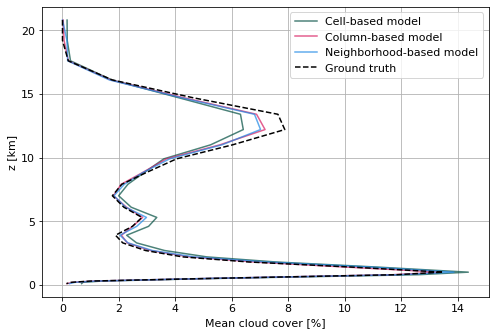

In [8]:
fig = plt.figure(figsize=(8,16/3))

ax = fig.add_subplot(111, xlabel='Mean cloud cover [%]', ylabel='z [km]')

ax.plot(np.array(pred_mean_cell_clc_narval), zg_mean_narval, color=green, alpha=.7)
ax.plot(np.array(pred_mean_column_clc_narval), zg_mean_narval, color=red, alpha=.7)
ax.plot(np.array(pred_mean_region_clc_narval), zg_mean_narval, color=blue, alpha=.7)
ax.plot(np.array(data_mean_clc_narval), zg_mean_narval, 'k--')
ax.grid(b=True)
ax.legend(['Cell-based model', 'Column-based model', 'Neighborhood-based model', 'Ground truth'])
# plt.gca().invert_yaxis()

plt.savefig('figures/narval_r2b4_on_r2b5_means.pdf')

**R2 plots**

NARVAL R2B4 cloud cover models on NARVAL R2B5 data

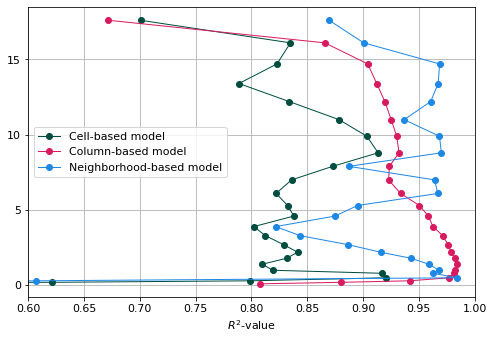

In [7]:
fig = plt.figure(figsize=(8,16/3))

ax = fig.add_subplot(111, xlim=(0.6,1), xlabel='$R^2$-value', yticks=[0,5,10,15])

ax.plot(np.array(r2_profile_cell_clc_narval)[2:], zg_mean_narval[2:], 'o-', color=green, linewidth=1)
ax.plot(np.array(r2_profile_column_clc_narval)[2:], zg_mean_narval[2:], 'o-', color=red, linewidth=1)
ax.plot(np.array(r2_profile_region_clc_narval)[2:], zg_mean_narval[2:], 'o-', color=blue, linewidth=1)
ax.grid(b=True)
ax.legend(['Cell-based model', 'Column-based model', 'Neighborhood-based model'])
# plt.gca().invert_yaxis()

# plt.savefig('figures/narval_r2b4_on_r2b5_r2.pdf')

In [5]:
print('Cell-based R2-mean: %.3f'%np.mean(np.array(r2_profile_cell_clc_narval)[2:]))
print('Column-based R2-mean: %.3f'%np.mean(np.array(r2_profile_column_clc_narval)[2:]))
print('Region-based R2-mean: %.3f'%np.mean(np.array(r2_profile_region_clc_narval)[2:]))

Cell-based R2-mean: 0.783
Column-based R2-mean: 0.927
Region-based R2-mean: 0.739
